In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Clean 2023 NIVA sensor data from Adventelva

Here we:
* Tidy the data columns
* Save the data to csv
* Manual QC of the data:
    * For each sensor variable, plot the data using an interactive plot
    * Add columns called "variablename_del" to the csv we just saved. This is a boolean column, which says whether or not the data for that datetime should be deleted
    * Manually go through the data by zooming in on the time series using the interactive plot and scrolling along. Sudden large jumps are dodgy data, unless there was a large change in e.g. discharge or water temperature at that time (it can be very helpful to also plot the discharge data, if available). If the data should be deleted, put a 1 in the corresponding datetime in the "_del" column in the csv.
    * Read in the manually-amended csv with the column saying which data points are dodgy for each variable. Use these data columns to remove dodgy points.
* Convert to 15 minute frequency and linearly interpolate to fill missing values (if the gap size isn't too big)

In [3]:
# Paths to files and folders
data_folder = r'../data/sensors'

# Raw data
in_file_raw_2023 = r'../data/sensors/adventelva_sensor_data_niva_2023_raw.csv'

# --------- Output --------------------
# Resampled data with 15 minute frequency (with gaps)
fname_intermediate = "adventelva_sensor_data_niva_2023_15-min-freq-with-gaps.csv"
fpath_intermediate = os.path.join(data_folder, fname_intermediate)

# Data with 15 minute frequency with QC column added manually using plots from this NB
fname_qc = "adventelva_sensor_data_niva_2023_15-min-freq-with-gaps_QC.csv"
fpath_qc = os.path.join(data_folder, fname_qc)

# Data with 15 minute frequency, cleaned, with gaps
out_fpath_cleaned_2023 = os.path.join(data_folder, 'adventelva_sensor_data_niva_2023_cleaned.csv')

# Data with 15 minute frequency, linearly interpolated gaps
out_fpath_interp_2023 = os.path.join(data_folder, 'adventelva_sensor_data_niva_2023_linear-interp.csv')

# Read in data

In [13]:
# Read in raw data, tidy, and save with 15 min frequency
# Takes a while, so comment out once done once

# df = pd.read_csv(in_file_raw_2023, index_col='Timestamp', parse_dates=True, dayfirst=True)

# # Remove '_Avg' suffix from column headings
# df.columns = df.columns.str.replace('_Avg', '')

# rename_dict = {
#     "CondValue (mS/m)": "Konduktivitet",
#     "PhValue (-)": "pH",
#     "Temp_water (degC)": "Temperatur",
#     "LevelValue (mm)": "Vannstand",
#     "Turbidity (NTU)": "Turbiditet",
# }

# df.rename(columns=rename_dict, inplace=True)

# # Drop other cols
# cols_to_keep = list(rename_dict.values())
# df = df.loc[:, cols_to_keep]

# # Convert units of vannstand from mm to m
# df['Vannstand'] = df['Vannstand'] * 0.001

# # Change units of conductivity from mS/m to the uS/cm
# df['Konduktivitet'] = df['Konduktivitet'] * 10

# Reindex to 15 minute, to make data gaps clear
# df = df.asfreq(freq="15min")

# Write to csv
# df.to_csv(fpath_intermediate)

In [4]:
# If already done the pre-processing of df to 15 min freq and manual QC, read it in
df = pd.read_csv(fpath_qc, index_col=0, parse_dates=True)
df.head()

/tmp/ipykernel_5919/1711355925.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(fpath_qc, index_col=0, parse_dates=True)


,Konduktivitet,Konduktivitet_del,pH,pH_del,Temperatur,Temperatur_del,Vannstand,Vannstand_del,Turbiditet,Turbiditet_del
Timestamp,,,,,,,,,,
2023-06-15 15:15:00,2383.0,0.0,7.352,0.0,5.584,0.0,0.2741,0.0,54.37,0.0
2023-06-15 15:30:00,2387.0,0.0,7.349,0.0,5.637,0.0,0.2746,0.0,53.71,0.0
2023-06-15 15:45:00,2388.0,0.0,7.348,0.0,5.719,0.0,0.2735,0.0,1694.00,1.0
2023-06-15 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-15 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# First plot, all vars (N.B. takes a while! Comment out if not interested)
# df.plot(subplots=True)

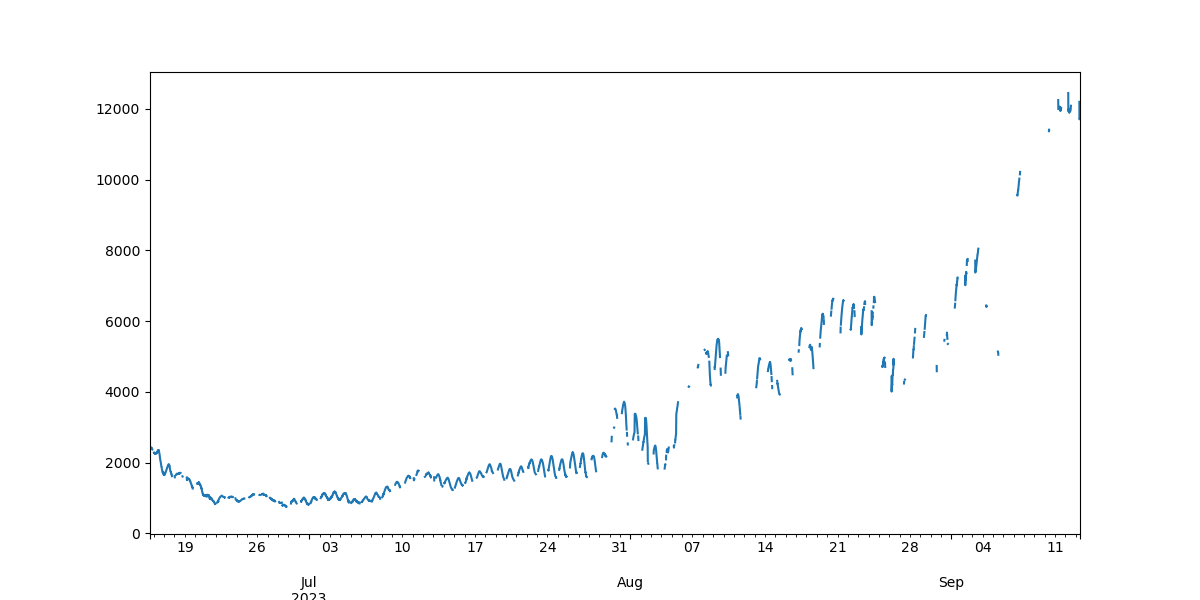

In [5]:
# Interactive plotting
%matplotlib widget

# Plot one variable at a time interactively for manual QC'ing
col = 'Konduktivitet'
df[col].plot(figsize=(12, 6))
plt.show()

**Comments:**

2023:
- Lots of data gaps in 2023. Will have to try a few methods for interpolating in a sensible way. But I think I'll have to give up once the gaps get too big, e.g. around the end of August.
- Conductivity, pH and vannstand are generally ok, just a couple of dodgy points, but need a detailed look through. Do this using the plot above, and manually enter '1' in the QC csv to indicate that the point should be deleted.
- pH: maybe just 1 dodgy value to delete, around 4th July, pH<7
- Turbidity: around 12 low values, around 0? Explore and drop. Hopefully just single values, not values around them that also need removing.

# Remove dodgy data points

In [8]:
# Check out low turbidity values
# print(df.loc[df['Turbiditet'] < 50])
# df.loc[df['Turbiditet'] < 3000, 'Turbiditet'].plot(marker='o', markersize=1, linestyle='')

In [21]:
# Pretty sure all turbidity values < 10 are an unhappy sensor. Delete
df.loc[df['Turbiditet'] < 10] = np.NaN

# Delete single values identified (manually) and highlighted in the input csv
df.loc[df["Konduktivitet_del"] == 1, "Konduktivitet"] = np.NaN
df.loc[df["pH_del"] == 1, "pH"] = np.NaN
df.loc[df["Temperatur_del"] == 1, "Temperatur"] = np.NaN
df.loc[df["Vannstand_del"] == 1, "Vannstand"] = np.NaN
df.loc[df["Turbiditet_del"] == 1, "Turbiditet"] = np.NaN

# Round all cols to a sensible number of decimal points
df['Vannstand'] = df['Vannstand'].round(3)
df['Konduktivitet'] = df['Konduktivitet'].round(0)
df['pH'] = df['pH'].round(3)
df['Turbiditet'] = df['Turbiditet'].round(1)

# Check for duplicate datetimes
duplicated = df.loc[df.index.duplicated(), :]
print(f"Number of duplicate datetime values in index: {len(duplicated)}\n")

# Drop QC columns
df.drop(columns=['Konduktivitet_del', 'pH_del', 'Temperatur_del', 'Vannstand_del', 'Turbiditet_del'], inplace=True)

# Write (roughly) cleaned df to csv
df.to_csv(out_fpath_cleaned_2023)

df.head()

Number of duplicate datetime values in index: 0



,Konduktivitet,pH,Temperatur,Vannstand,Turbiditet
Timestamp,,,,,
2023-06-15 15:15:00,2383.0,7.352,5.584,0.274,54.4
2023-06-15 15:30:00,2387.0,7.349,5.637,0.275,53.7
2023-06-15 15:45:00,2388.0,7.348,5.719,0.274,NaN
2023-06-15 16:00:00,NaN,NaN,NaN,NaN,NaN
2023-06-15 16:15:00,NaN,NaN,NaN,NaN,NaN


# Linear interpolation of data gaps

In [22]:
# Also linearly interpolate and write that to csv (as the benchmark filling method)
interp_df = df.interpolate()
interp_df.to_csv(out_fpath_interp_2023)
interp_df.head()

,Konduktivitet,pH,Temperatur,Vannstand,Turbiditet
Timestamp,,,,,
2023-06-15 15:15:00,2383.000000,7.352000,5.584000,0.274000,54.400
2023-06-15 15:30:00,2387.000000,7.349000,5.637000,0.275000,53.700
2023-06-15 15:45:00,2388.000000,7.348000,5.719000,0.274000,55.525
2023-06-15 16:00:00,2392.333333,7.353667,5.758667,0.275333,57.350
2023-06-15 16:15:00,2396.666667,7.359333,5.798333,0.276667,59.175
